**DECISION TREE -> CONTRUCTION & INTERPRETATION**
========================================================================================================================================

*This file should be in the same folder as the "Randoms", "Softmax" and "Without_Softmax" folders*

In [5]:
import pandas as pd
import numpy as np
from collections import Counter
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score

*Auxiliary Functions*

In [6]:
def entropy(data):
    labels = data.iloc[:, -1]
    total = len(labels)
    counts = Counter(labels)
    return -sum((count / total) * math.log2(count / total) for count in counts.values())

def split_dataset(data, feature, value, continuous=False):
    if continuous:
        left = data[data[feature] <= value].copy()
        right = data[data[feature] > value].copy()
    else:
        left = data[data[feature] == value].copy()
        right = data[data[feature] != value].copy()
    return left, right

def information_gain_categorical(data, feature):
    base_entropy = entropy(data)
    values = data[feature].unique()
    weighted_entropy = 0

    for value in values:
        subset = data[data[feature] == value]
        weighted_entropy += (len(subset) / len(data)) * entropy(subset)
        
    return base_entropy - weighted_entropy

def information_gain_continuous(data, feature):
    base_entropy = entropy(data)
    values = data[feature].sort_values().unique()
    best_gain = 0
    best_threshold = None

    for i in range(1, len(values)):
        threshold = (values[i - 1] + values[i]) / 2
        left, right = split_dataset(data, feature, threshold, continuous=True)
        
        if len(left) == 0 or len(right) == 0:
            continue

        weighted_entropy = (len(left) / len(data)) * entropy(left) + \
                           (len(right) / len(data)) * entropy(right)
        gain = base_entropy - weighted_entropy

        if gain > best_gain:
            best_gain = gain
            best_threshold = threshold
    
    return best_gain, best_threshold

def add_n_pieces_column(csv_path):
    df = pd.read_csv(csv_path)
    df['n_pieces'] = df.apply(lambda row: sum(cell in ['X', 'O'] for cell in row), axis=1)
    cols = ['n_pieces'] + [col for col in df.columns if col != 'n_pieces']
    df = df[cols]
    df.to_csv(csv_path, index=False)

def add_aggregate_new_features(df):
    cell_cols = [col for col in df.columns if col.startswith('cell_')]
    df['count_X'] = (df[cell_cols] == 'X').sum(axis=1)
    df['count_O'] = (df[cell_cols] == 'O').sum(axis=1)
    df['diff_XO'] = df['count_X'] - df['count_O']
    return df

def drop_partial_duplicates(df, percent=0.5):
    dups = df[df.duplicated(keep=False)]
    n_remove = int(len(dups) * percent)
    idx_to_remove = dups.sample(n=n_remove, random_state=42).index
    return df.drop(idx_to_remove)

def plot_tree(node, depth=0, x=0.5, y=1.0, dx=0.4, ax=None, parent_pos=None, label=''):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
        ax.set_axis_off()

    if node.result is not None:
        text = f'Predict:\n{node.result}'
    else:
        text = f'{node.feature}'

    ax.text(x, y, text, ha='center', va='center',
            bbox=dict(boxstyle="round", facecolor='lightblue'))

    if parent_pos is not None:
        ax.plot([parent_pos[0], x], [parent_pos[1], y], 'k-')
        mx, my = (parent_pos[0] + x)/2, (parent_pos[1] + y)/2
        ax.text(mx, my, label, fontsize=9)

    if node.children:
        n = len(node.children)
        i = 0
        for value, child in node.children.items():
            new_x = x + dx * (i - (n-1)/2)
            new_y = y - 0.25 / (1 + 0.15*depth)
            plot_tree(child, depth + 1, new_x, new_y, dx / 1.2, ax, (x, y), str(value))
            i += 1

    if depth == 0:
        plt.show()

df = ["datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax.csv","datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax83k.csv","datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax217k.csv","datasets/Datasets_decision_tree/Without_Softmax/MCTSGeneratedDatasetWithoutSoftmax.csv","datasets/Datasets_decision_tree/Randoms/Randoms_Together.csv"]
for i in df:
    add_n_pieces_column(i)


*DECISION TREE'S ALGORITHM - ID3*

In [5]:
class DecisionNode:
    def __init__(self, feature=None, children=None, result=None):
        self.feature = feature
        self.children = children  # dict: value -> subtree
        self.result = result

class ID3Tree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, data, features):
        self.root = self._id3(data, features, depth=0)

    def _id3(self, data, features, depth):
        labels = data['50kIter']
        mode_val = labels.mode()
        if len(set(labels)) == 1 or len(features) == 0 or (self.max_depth is not None and depth >= self.max_depth):
            return DecisionNode(result=mode_val.iloc[0] if not mode_val.empty else None)
        best_gain = 0
        best_feature = None
        for feature in features:
            gain = information_gain_categorical(data, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
        if best_gain == 0:
            return DecisionNode(result=mode_val.iloc[0] if not mode_val.empty else None)
        next_features = [f for f in features if f != best_feature]
        children = {}
        for value, subset in data.groupby(best_feature):
            children[value] = self._id3(subset, next_features, depth + 1)
        return DecisionNode(feature=best_feature, children=children)

    def classify(self, row):
        node = self.root
        while node.result is None:
            value = row[node.feature]
            if value in node.children:
                node = node.children[value]
            else:
                return None
        return node.result

**SIMPLE DECISION TREE CONSTRUCTION AND EVALUATION**

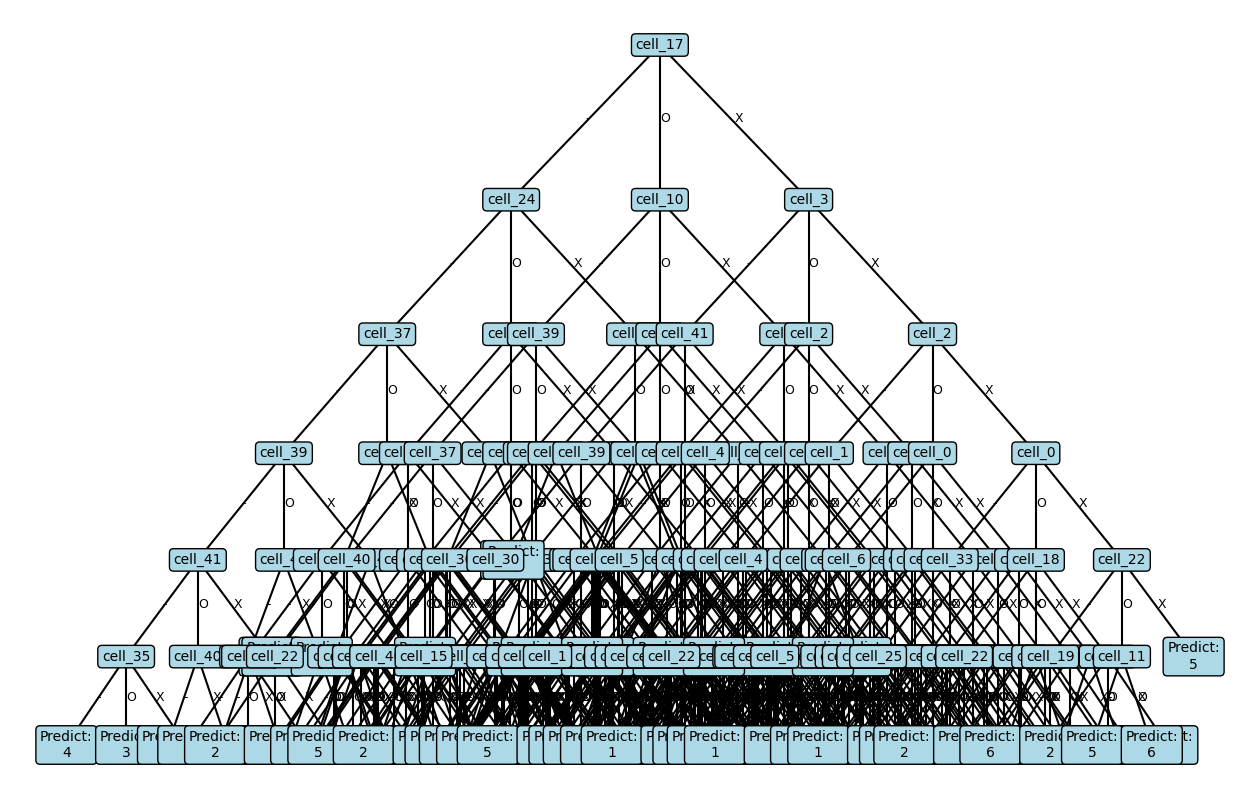


Accuracy ID3 (max_depth=6): 0.4466 (evaluated 11966/11969)
Balanced Accuracy: 0.4131
Classification Report:
              precision    recall  f1-score   support

           1       0.28      0.41      0.33      1592
           2       0.35      0.35      0.35      1593
           3       0.40      0.44      0.42      1682
           4       0.79      0.81      0.80      2518
           5       0.39      0.34      0.36      1670
           6       0.47      0.22      0.30      1419
           7       0.32      0.34      0.33      1492

    accuracy                           0.45     11966
   macro avg       0.43      0.41      0.41     11966
weighted avg       0.46      0.45      0.44     11966

Confusion Matrix:
[[ 645  239  182   39  164   32  291]
 [ 285  554  164  115  171   77  227]
 [ 279  175  739  133  180   74  102]
 [  81   61  123 2028   69   71   85]
 [ 293  230  202  153  562   43  187]
 [ 278  191  246   76  130  306  192]
 [ 424  119  181   36  176   46  510]]

Accuracy

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax.csv").drop(columns=["10kIter","20kIter","30kIter","40kIter","n_pieces"])
features = df.columns[:-1]
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)

depths = [6, 10, 15, 20]
for d in depths:
    tree = ID3Tree(max_depth=d)
    tree.fit(train_data, X_train.columns)
    y_pred = [tree.classify(row) for _, row in X_test.iterrows()]
    valid_idx = [i for i, yp in enumerate(y_pred) if yp is not None and yp == yp]
    if valid_idx:
        y_test_arr = y_test.reset_index(drop=True).to_numpy()
        y_pred_arr = np.array(y_pred, dtype=object)
        y_test_valid = [y_test_arr[i] for i in valid_idx]
        y_pred_valid = [y_pred_arr[i] for i in valid_idx]
        acc = accuracy_score(y_test_valid, y_pred_valid)
        bal_acc = balanced_accuracy_score(y_test_valid, y_pred_valid)
        if d == 6:
            plot_tree(tree.root)
        print(f"\nAccuracy ID3 (max_depth={d}): {acc:.4f} (analysed {len(valid_idx)}/{len(y_pred)})")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test_valid, y_pred_valid))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test_valid, y_pred_valid))
    else:
        print(f"Accuracy ID3 (max_depth={d}): No valid predicts!")


**ADVANCED DECISION TREE (+PRECISE?)**

In [7]:
class MultiPhaseID3:
    def __init__(self, early_range, mid_range, late_range, **tree_kwargs):
        self.early_tree = ID3Tree(**tree_kwargs)
        self.mid_tree = ID3Tree(**tree_kwargs)
        self.late_tree = ID3Tree(**tree_kwargs)
        self.early_range = early_range
        self.mid_range = mid_range
        self.late_range = late_range

    def fit(self, df, features, n_pieces_col='n_pieces'):
        df_early = df[df[n_pieces_col].between(*self.early_range)]
        df_mid = df[df[n_pieces_col].between(*self.mid_range)]
        df_late = df[df[n_pieces_col].between(*self.late_range)]
        self.early_tree.fit(df_early, features)
        self.mid_tree.fit(df_mid, features)
        self.late_tree.fit(df_late, features)

    def predict(self, X, n_pieces_col='n_pieces'):
        n_pieces = X[n_pieces_col]
        preds = pd.Series(index=X.index, dtype=object)

        idx_early = n_pieces.between(*self.early_range)
        idx_mid = n_pieces.between(*self.mid_range)
        idx_late = n_pieces.between(*self.late_range)

        for idx, row in X[idx_early].iterrows():
            preds[idx] = self.early_tree.classify(row)
        for idx, row in X[idx_mid].iterrows():
            preds[idx] = self.mid_tree.classify(row)
        for idx, row in X[idx_late].iterrows():
            preds[idx] = self.late_tree.classify(row)
        return preds

*Tester functions*

In [ ]:
def ID3TotalTest(df, early_range=(0,13), mid_range=(14,27), late_range=(28,41), max_depth=10, test=0.2, trigger=1):
    if trigger == 1:
        df = df.drop(columns=["10kIter","20kIter","30kIter","40kIter"])
    features = [col for col in df.columns if col not in ['n_pieces', '50kIter']]

    # Split 80/20 standard
    def split(df_part):
        X = df_part[features + ['n_pieces']]
        y = df_part['50kIter']
        return train_test_split(X, y, test_size = test, random_state=42)

    data_splits = [split(df[df['n_pieces'].between(*rng)]) for rng in [early_range, mid_range, late_range]]
    X_train = pd.concat([s[0] for s in data_splits])
    X_test  = pd.concat([s[1] for s in data_splits])
    y_train = pd.concat([s[2] for s in data_splits])
    y_test  = pd.concat([s[3] for s in data_splits])

    train_data = pd.concat([X_train, y_train], axis=1)
    multi_tree = MultiPhaseID3(
        early_range=early_range, mid_range=mid_range, late_range=late_range, max_depth=max_depth,
    )
    multi_tree.fit(train_data, features, n_pieces_col='n_pieces')

    #Efficient prediction
    y_pred = multi_tree.predict(X_test, n_pieces_col='n_pieces')
    valid_mask = (~y_pred.isnull()) & (~y_test.isnull())
    y_test_valid = y_test[valid_mask].astype(str)
    y_pred_valid = y_pred[valid_mask].astype(str)

    acc = accuracy_score(y_test_valid, y_pred_valid)
    bal_acc = balanced_accuracy_score(y_test_valid, y_pred_valid)
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_valid, y_pred_valid))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_valid, y_pred_valid))

    n_pieces_test = X_test['n_pieces']
    for name, rng in zip(['Early', 'Mid', 'Late'], [early_range, mid_range, late_range]):
        mask = n_pieces_test.between(*rng) & valid_mask
        if mask.sum() > 0:
            acc_phase = accuracy_score(y_test[mask].astype(str), y_pred[mask].astype(str))
            print(f"Accuracy {name} game: {acc_phase:.4f} (n={mask.sum()})")
        else:
            print(f"Accuracy {name} game: No examples in this phase.")

    return acc, multi_tree

def ID3tree_test(df, depth = 20, test=0.2):
    df = df.drop(columns=["10kIter","20kIter","30kIter","40kIter","n_pieces"])
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test, random_state=42)
    train_data = pd.concat([X_train, y_train], axis=1)
    tree = ID3Tree(max_depth=depth)
    tree.fit(train_data, X_train.columns)
    y_pred = [tree.classify(row) for _, row in X_test.iterrows()]
    valid_idx = [i for i, yp in enumerate(y_pred) if yp is not None and yp == yp]
    if valid_idx:
        y_test_arr = y_test.reset_index(drop=True).to_numpy()
        y_pred_arr = np.array(y_pred, dtype=object)
        y_test_valid = [y_test_arr[i] for i in valid_idx]
        y_pred_valid = [y_pred_arr[i] for i in valid_idx]
        acc = accuracy_score(y_test_valid, y_pred_valid)
        bal_acc = balanced_accuracy_score(y_test_valid, y_pred_valid)
        print(f"\nAccuracy ID3 (max_depth={d}): {acc:.4f} (analysed {len(valid_idx)}/{len(y_pred)})")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test_valid, y_pred_valid))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test_valid, y_pred_valid))
    else:
        print(f"Accuracy (max_depth={d}): No valid predictions!")

**Comparing MultiPhaseDT with SingleDT**

*Testing depths*

In [ ]:
df = pd.read_csv("datastSoftmax/MCTSGeneratedDatasetSoftmax.csv")

print("Max Depth 10:")
acc, multi_tree = ID3TotalTest(df)

print("\nMax Depth 20:")
acc_59, multi_tree_soft_59 = ID3TotalTest(df, max_depth=20)

# print("\nMax Depth 25:")                                 NOT WORTH IT SEE Results
# acc, multi_tree = ID3TotalTest(df, max_depth=25)

# print("\nMax Depth 30:")
# acc, multi_tree = ID3TotalTest(df, max_depth=30)

# plot_tree(multi_tree.early_tree.root)
# plot_tree(multi_tree.mid_tree.root)
# plot_tree(multi_tree.late_tree.root)

Max Depth 10:
Accuracy: 0.6788
Balanced Accuracy: 0.6603

Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.62      0.58      1587
           2       0.62      0.64      0.63      1566
           3       0.65      0.70      0.67      1690
           4       0.88      0.87      0.88      2508
           5       0.68      0.64      0.66      1663
           6       0.69      0.57      0.62      1430
           7       0.58      0.60      0.59      1438

    accuracy                           0.68     11882
   macro avg       0.67      0.66      0.66     11882
weighted avg       0.68      0.68      0.68     11882

Confusion Matrix:
[[ 979  129  120   32   89   74  164]
 [ 155  998  105   38   93   62  115]
 [ 145   94 1183   58   61   64   85]
 [  54   92   60 2180   56   33   33]
 [ 153  101  150   57 1057   51   94]
 [ 117  103  130   66   80  811  123]
 [ 175   96   82   38  114   76  857]]
Accuracy Early game: 0.8309 (n=5606)


*For a max depth of 20+ there isn't improvements shown, at leats by the stats shown, incresing depth even further may result in overfitting.*

**Analysing a bigger Dataset (+83k)**

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax83k.csv")

print("\nMax Depth 15:")
acc_83_1, multi_tree_soft_83_1 = ID3TotalTest(df, max_depth=15)
print("\nMax Depth 20:")
acc_83_2, multi_tree_soft_83_2 = ID3TotalTest(df, max_depth=20)
# print("\nMax Depth 30:")
# acc_83_3, multi_tree_soft_83_3 = ID3TotalTest(df, max_depth=30)           NOT WORTH IT SEE Results
# print("\nMax Depth 40:")
# acc_83_4, multi_tree_soft_83_4 = ID3TotalTest(df, max_depth=40)


Max Depth 15:
Accuracy: 0.6356
Balanced Accuracy: 0.6157

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.51      0.51      2022
           2       0.60      0.58      0.59      2072
           3       0.65      0.60      0.63      2361
           4       0.88      0.84      0.86      3468
           5       0.57      0.66      0.61      2210
           6       0.60      0.59      0.59      2106
           7       0.51      0.52      0.52      2068

    accuracy                           0.64     16307
   macro avg       0.62      0.62      0.62     16307
weighted avg       0.64      0.64      0.64     16307

Confusion Matrix:
[[1041  179  159   35  156  182  270]
 [ 185 1205  133   59  212  113  165]
 [ 182  120 1427  100  254  123  155]
 [  82  101   88 2923   97  105   72]
 [ 160  129  111   73 1451  112  174]
 [ 180  113  112   80  192 1235  194]
 [ 254  157  167   61  168  179 1082]]
Accuracy Early game: 0.8282 (n=7788)

*All of the stats seem way worse, it could be caused by having too many duplicated lines.*

In [11]:
print("Duplicated lines:", df.duplicated().sum())

Duplicated lines: 32395


In [12]:
df = df.drop_duplicates()
print("\nDataset w/o Dups:")
acc_83_1, multi_tree_soft_83_no_dup = ID3TotalTest(df, max_depth=20)


Dataset w/o Dups:
Accuracy: 0.4270
Balanced Accuracy: 0.4314

Classification Report:
              precision    recall  f1-score   support

           1       0.41      0.45      0.43      1696
           2       0.41      0.41      0.41      1356
           3       0.45      0.43      0.44      1383
           4       0.53      0.53      0.53       875
           5       0.43      0.39      0.41      1426
           6       0.40      0.39      0.39      1363
           7       0.41      0.43      0.42      1681

    accuracy                           0.43      9780
   macro avg       0.43      0.43      0.43      9780
weighted avg       0.43      0.43      0.43      9780

Confusion Matrix:
[[757 169 148  54 155 153 260]
 [195 561 120  68 125 114 173]
 [188 136 589  79  94 108 189]
 [ 72  66  70 460  67  83  57]
 [200 161 126  68 552 146 173]
 [170 113 135  74 144 527 200]
 [270 147 131  61 153 189 730]]
Accuracy Early game: 0.5384 (n=2110)
Accuracy Mid game: 0.3922 (n=5918)
Accuracy 

*Did not work. What about taking more advantage of the data:*

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax83k.csv")
print("Higher training size:")
acc_83_2, multi_tree_soft_83_lower_test = ID3TotalTest(df, max_depth=20, test=0.1)

Higher training size:
Accuracy: 0.6428
Balanced Accuracy: 0.6236

Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.51      0.51       998
           2       0.61      0.59      0.60      1014
           3       0.64      0.60      0.62      1183
           4       0.88      0.84      0.86      1730
           5       0.59      0.69      0.64      1140
           6       0.61      0.59      0.60      1042
           7       0.54      0.55      0.54      1059

    accuracy                           0.64      8166
   macro avg       0.62      0.62      0.62      8166
weighted avg       0.65      0.64      0.64      8166

Confusion Matrix:
[[ 504   83   88   20   83   93  127]
 [  92  598   72   27   91   54   80]
 [  85   62  714   44  140   64   74]
 [  32   43   53 1450   55   57   40]
 [  70   64   44   41  789   59   73]
 [  93   46   70   34   92  616   91]
 [ 120   81   82   34   90   74  578]]
Accuracy Early game: 0.8228 (

Slighty better, it shows that although it has more lines, it only has 9000 (900x10) lines representing late game scenarios, and 33670(3367x10) for mid game, which can see like a lot, but being the most complex state, this number of lines its not enough for pattern recognition, the same for late game.

**Analysing an even bigger dataset (200k+)**

*Analysing depths*


In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax217k.csv")

print("\nMax Depth 20:")
acc_217, multi_tree_soft_217 = ID3TotalTest(df, max_depth=20, test = 0.08)
# print("\nMax Depth 30:")
# acc_217_1, multi_tree_soft_217_1 = ID3TotalTest(df, max_depth=30, test = 0.08)     NOT WORTH IT SEE Results
# print("\nMax Depth 40:")
# acc_217_2, multi_tree_soft_217_2 = ID3TotalTest(df, max_depth=40, test = 0.08)
# print("\nMax Depth 50:")
# acc_217_3, multi_tree_soft_217_3 = ID3TotalTest(df, max_depth=50, test = 0.08)


Max Depth 20:
Accuracy: 0.6794
Balanced Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.60      0.58      2139
           2       0.66      0.65      0.65      2251
           3       0.71      0.66      0.68      2552
           4       0.89      0.87      0.88      3600
           5       0.63      0.68      0.65      2348
           6       0.66      0.61      0.63      2189
           7       0.54      0.57      0.55      2021

    accuracy                           0.68     17100
   macro avg       0.66      0.66      0.66     17100
weighted avg       0.68      0.68      0.68     17100

Confusion Matrix:
[[1280  159  138   48  143  131  240]
 [ 174 1454  115   54  197   88  169]
 [ 158  118 1684   97  197  118  180]
 [  66   88   90 3121   97   90   48]
 [ 173  123  130   68 1590   97  167]
 [ 194  135   98   63  180 1343  176]
 [ 260  125  123   50  134  183 1146]]
Accuracy Early game: 0.8576 (n=8151)

In [18]:
print("Duplicated lines:", df.duplicated().sum())
print("\n",df['50kIter'].value_counts())

Duplicated lines: 97920

 50kIter
4    45495
3    31030
5    30564
2    27842
1    27695
6    27360
7    27234
Name: count, dtype: int64


In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax217k.csv").drop_duplicates()
acc_217_dup, multi_tree_soft_217_dup = ID3TotalTest(df, max_depth=20, test = 0.08)

Accuracy: 0.4477
Balanced Accuracy: 0.4504

Classification Report:
              precision    recall  f1-score   support

           1       0.45      0.47      0.46      1731
           2       0.43      0.43      0.43      1316
           3       0.47      0.47      0.47      1245
           4       0.55      0.51      0.53       720
           5       0.45      0.40      0.42      1302
           6       0.41      0.41      0.41      1210
           7       0.43      0.46      0.44      1684

    accuracy                           0.45      9208
   macro avg       0.46      0.45      0.45      9208
weighted avg       0.45      0.45      0.45      9208

Confusion Matrix:
[[805 164 164  48 134 166 250]
 [193 565  91  57 109 120 181]
 [139 110 588  49  97 112 150]
 [ 55  61  63 368  54  48  71]
 [183 154  96  49 527 112 181]
 [160 119 112  53  96 501 169]
 [271 140 133  50 164 158 768]]
Accuracy Early game: 0.5332 (n=1628)
Accuracy Mid game: 0.4207 (n=5753)
Accuracy Late game: 0.4565 (

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax217k.csv")
df = drop_partial_duplicates(df, percent=0.75)
acc_217_dup_par, multi_tree_soft_217_dup_par = ID3TotalTest(df, max_depth=20, test = 0.08)

Accuracy: 0.5028
Balanced Accuracy: 0.5071

Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.48      0.46      1684
           2       0.48      0.49      0.48      1389
           3       0.52      0.48      0.50      1502
           4       0.75      0.73      0.74      1301
           5       0.49      0.50      0.49      1429
           6       0.46      0.43      0.44      1358
           7       0.44      0.46      0.45      1679

    accuracy                           0.50     10342
   macro avg       0.51      0.51      0.51     10342
weighted avg       0.50      0.50      0.50     10342

Confusion Matrix:
[[802 150 140  53 148 137 254]
 [182 677  98  51 136  87 158]
 [190 105 720  54 136 126 171]
 [ 56  68  58 944  60  62  53]
 [167 125  94  66 708 104 165]
 [179 141 122  45 125 583 163]
 [258 141 149  51 145 169 766]]
Accuracy Early game: 0.7321 (n=2841)
Accuracy Mid game: 0.4130 (n=5678)
Accuracy Late game: 0.4251 (

*The much larger dataset, still doesn't return a much more intelligent MultiPhase DT, at least rated by the evaluation scores, although there are many duplicates, we have already seen that removing them, returns worse evaluation scores, but it doesn't mean it is any less intelligent. There also is a small difference in MCTS move counts, so let's try something different and add new features to the scene: number of pieces X, and O, difference between X and O pieces*

In [21]:
# using the add_aggregate_new_features function to add them to df
def ID3TotalTestV2(df, early_range=(0,13), mid_range=(14,27), late_range=(28,41), max_depth=10, test=0.2, trigger=1):
    df = add_aggregate_new_features(df)
    if trigger == 1:
        df = df.drop(columns=["10kIter","20kIter","30kIter","40kIter"], errors='ignore')
    
    features = [col for col in df.columns if col not in ['n_pieces', '50kIter']]

    def split(df_part):
        X = df_part[features + ['n_pieces']]
        y = df_part['50kIter']
        return train_test_split(X, y, test_size=test, random_state=42)

    data_splits = [split(df[df['n_pieces'].between(*rng)]) for rng in [early_range, mid_range, late_range]]
    X_train = pd.concat([s[0] for s in data_splits])
    X_test  = pd.concat([s[1] for s in data_splits])
    y_train = pd.concat([s[2] for s in data_splits])
    y_test  = pd.concat([s[3] for s in data_splits])

    train_data = pd.concat([X_train, y_train], axis=1)
    multi_tree = MultiPhaseID3(
        early_range=early_range, mid_range=mid_range, late_range=late_range, max_depth=max_depth,
    )
    multi_tree.fit(train_data, features, n_pieces_col='n_pieces')

    y_pred = multi_tree.predict(X_test, n_pieces_col='n_pieces')
    valid_mask = (~y_pred.isnull()) & (~y_test.isnull())
    y_test_valid = y_test[valid_mask].astype(str)
    y_pred_valid = y_pred[valid_mask].astype(str)

    acc = accuracy_score(y_test_valid, y_pred_valid)
    bal_acc = balanced_accuracy_score(y_test_valid, y_pred_valid)
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_valid, y_pred_valid))
    print("COnfusion Matrix:")
    print(confusion_matrix(y_test_valid, y_pred_valid))

    n_pieces_test = X_test['n_pieces']
    for name, rng in zip(['Early', 'Mid', 'Late'], [early_range, mid_range, late_range]):
        mask = n_pieces_test.between(*rng) & valid_mask
        if mask.sum() > 0:
            acc_phase = accuracy_score(y_test[mask].astype(str), y_pred[mask].astype(str))
            print(f"Accuracy {name} game: {acc_phase:.4f} (n={mask.sum()})")
        else:
            print(f"Accuracy {name} game: No examples in this phase.")

    return acc, multi_tree

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax217k.csv")
acc_217_v2, multi_tree_217_v2 = ID3TotalTestV2(df, max_depth=20, test=0.08)

Accuracy: 0.6670
Balanced Accuracy: 0.6468

Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.56      0.55      2124
           2       0.63      0.61      0.62      2254
           3       0.71      0.66      0.68      2533
           4       0.88      0.87      0.87      3600
           5       0.61      0.68      0.65      2340
           6       0.63      0.60      0.62      2185
           7       0.53      0.54      0.53      2007

    accuracy                           0.67     17043
   macro avg       0.65      0.65      0.65     17043
weighted avg       0.67      0.67      0.67     17043

COnfusion Matrix:
[[1195  167  143   59  142  154  264]
 [ 189 1383  121   72  212  103  174]
 [ 153  119 1676  100  215  121  149]
 [  59   94   84 3118  101   97   47]
 [ 158  122  115   78 1597  121  149]
 [ 193  157  101   60  180 1314  180]
 [ 264  157  124   53  161  164 1084]]
Accuracy Early game: 0.8539 (n=8165)
Accuracy Mid g

*Still didn't work, didn't change anything at all in terms of result. We though it could help adding more game states, so the DT could be more precise, but, after further consideration, we arrived to the conclusion that it won't help us much, since it would be limitating the data once more, and the patterns don't change that much in states with less range. Let's compare a simple DT made by the same dataset and see if the MultiPhase is still worth it:*

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax217k.csv")
ID3tree_test(df, test=0.08)


Accuracy ID3 (max_depth=20): 0.6864 (analysed 17123/17378)
Balanced Accuracy: 0.6702
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.61      0.59      2198
           2       0.65      0.64      0.65      2227
           3       0.70      0.65      0.68      2410
           4       0.90      0.86      0.88      3585
           5       0.64      0.70      0.67      2432
           6       0.66      0.64      0.65      2120
           7       0.56      0.59      0.58      2151

    accuracy                           0.69     17123
   macro avg       0.67      0.67      0.67     17123
weighted avg       0.69      0.69      0.69     17123

Confusion Matrix:
[[1331  155  136   39  143  143  251]
 [ 174 1424  102   54  196  116  161]
 [ 166  114 1571   85  190  107  177]
 [  63   97   76 3100   97   89   63]
 [ 179  111   98   71 1706   94  173]
 [ 144  132  108   51  174 1360  151]
 [ 260  149  144   45  142  149 1262]]


Disappointedly so, the result don't differ anything from the normal Multi-Tree created by this dataset.

*But why is it that the lowest data weighted dataset seems more intelligent?*

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Softmax/MCTSGeneratedDatasetSoftmax.csv")
print("Duplicated lines:", df.duplicated().sum())
print("Total Lines:", len(df))

Duplicated lines: 30484
Total Lines: 59842


*The original has less non-duplicate lines, so, statistically, by learning more of the duplicate ones, when testing, the duplicate patterns are shown in the resuts.*

**Analysing a dataset generated without Softmax, only using MCTS**

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Without_Softmax/MCTSGeneratedDatasetWithoutSoftmax.csv")
print("Duplicated Lines:" ,df.duplicated().sum())
acc_no, multi_tree_no_soft = ID3TotalTest(df, max_depth=20, trigger=2)

Duplicated Lines: 75863
Accuracy: 0.8541
Balanced Accuracy: 0.8508

Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.89      0.86      2308
           2       0.87      0.80      0.83      2228
           3       0.85      0.83      0.84      2464
           4       0.92      0.90      0.91      3257
           5       0.75      0.88      0.81      2353
           6       0.91      0.78      0.84      2194
           7       0.84      0.87      0.86      2173

    accuracy                           0.85     16977
   macro avg       0.86      0.85      0.85     16977
weighted avg       0.86      0.85      0.85     16977

Confusion Matrix:
[[2055   39   65   22   33   21   73]
 [  86 1780   34   24  153   33  118]
 [  55   40 2047    5  257   18   42]
 [  38   79  121 2935   48   10   26]
 [  34   25   65   97 2075   22   35]
 [ 106   35   50   80  158 1711   54]
 [  70   48   24   28   50   56 1897]]
Accuracy Early game: 0.8517

*Even though it looks promising, the results from this dataset are deceving, it has over 75k duplicates, from 85k total lines, so it's not a surprise that it has such high evaluation scores. The multi-tree with no Softmax may be good (85.4%) at guessing its own values, but, in different environments, it maybe be the multi-tree / simple-tree with the worst results.*

**Analysing a randomly dataset (random states)**

In [ ]:
df = pd.read_csv("datasets/Datasets_decision_tree/Randoms/Randoms_Together.csv")
print("Duplicated Lines:" ,df.duplicated().sum())
acc_rand, multi_tree_randoms_together = ID3TotalTest(df, max_depth=30, trigger=2)

Duplicated Lines: 15140
Accuracy: 0.3952
Balanced Accuracy: 0.3671

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.45      0.46      3860
           2       0.33      0.33      0.33      2185
           3       0.33      0.32      0.33      2083
           4       0.54      0.56      0.55      3426
           5       0.29      0.29      0.29      1878
           6       0.24      0.24      0.24      1556
           7       0.36      0.38      0.37      1954

    accuracy                           0.40     16942
   macro avg       0.37      0.37      0.37     16942
weighted avg       0.40      0.40      0.40     16942

Confusion Matrix:
[[1722  374  346  403  335  271  409]
 [ 393  712  229  272  209  189  181]
 [ 311  208  672  269  237  186  200]
 [ 344  251  241 1921  248  207  214]
 [ 329  197  209  257  544  175  167]
 [ 278  202  180  205  160  378  153]
 [ 305  207  167  207  166  156  746]]
Accuracy Early game: 0.5246

*The results are pretty obvious, too much randomness is going to bring little real scenarious to the DT, at least smart ones, and it isn't able to explore patterns, which is important.*

**CONCLUSION**
=======================================

*After many Decision Trees created, we can say, without a doubt, the smarter ones are the ones created by datasets generated with the Softmax function. They are the most complete ones and more robust. They show the balance between precision and generalization.*

*But for these datasets (reasonably small), data distribution and specially this game, the Multi-Trees do not differ much from the simpler ones. This reveals that, even though our intuition was that partitionalising the game into phases could bring us better results, the game patterns don't change much between phases, meaning that a simple Tree may be the more efficient and pratical way.*

RESULTS
=============

================== SOFTMAX ORIGINAL ========================

Duplicated lines: 30484
Total Lines: 59842

-> Simple:

- Depth Testing:

Accuracy ID3 (max_depth=6): 0.4466 (analysed 11966/11969)
Balanced Accuracy: 0.4131
Classification Report:
              precision    recall  f1-score   support

           1       0.28      0.41      0.33      1592
           2       0.35      0.35      0.35      1593
           3       0.40      0.44      0.42      1682
           4       0.79      0.81      0.80      2518
           5       0.39      0.34      0.36      1670
           6       0.47      0.22      0.30      1419
           7       0.32      0.34      0.33      1492

    accuracy                           0.45     11966
   macro avg       0.43      0.41      0.41     11966
weighted avg       0.46      0.45      0.44     11966

Confusion Matrix:
[[ 645  239  182   39  164   32  291]
 [ 285  554  164  115  171   77  227]
 [ 279  175  739  133  180   74  102]
 [  81   61  123 2028   69   71   85]
 [ 293  230  202  153  562   43  187]
 [ 278  191  246   76  130  306  192]
 [ 424  119  181   36  176   46  510]]

-----------------

Accuracy ID3 (max_depth=10): 0.6115 (analysed 11909/11969)
Balanced Accuracy: 0.5868
Classification Report:
              precision    recall  f1-score   support

           1       0.46      0.55      0.50      1584
           2       0.56      0.54      0.55      1585
           3       0.59      0.59      0.59      1679
           4       0.88      0.88      0.88      2509
           5       0.58      0.57      0.58      1656
           6       0.55      0.49      0.52      1413
           7       0.50      0.49      0.49      1483

    accuracy                           0.61     11909
   macro avg       0.59      0.59      0.59     11909
weighted avg       0.61      0.61      0.61     11909

Confusion Matrix:
[[ 865  127   93   33  161  103  202]
 [ 203  862  124   44  121  120  111]
 [ 173  132  996   65   90  114  109]
 [  61   72   55 2201   46   37   37]
 [ 142  128  150   76  941   87  132]
 [ 172   96  150   53  117  697  128]
 [ 254  126  114   30  134  105  720]]

-----------------

Accuracy ID3 (max_depth=15): 0.7398 (analysed 11847/11969)
Balanced Accuracy: 0.7248
Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.68      0.67      1574
           2       0.72      0.73      0.72      1574
           3       0.70      0.73      0.71      1673
           4       0.90      0.90      0.90      2506
           5       0.74      0.70      0.72      1642
           6       0.71      0.68      0.70      1404
           7       0.65      0.66      0.65      1474

    accuracy                           0.74     11847
   macro avg       0.73      0.72      0.73     11847
weighted avg       0.74      0.74      0.74     11847

Confusion Matrix:
[[1074   91   77   19   86   84  143]
 [  90 1143   87   25   66   72   91]
 [ 110   77 1214   55   61   74   82]
 [  36   64   47 2260   37   30   32]
 [  79   73  124   65 1142   57  102]
 [  92   64  100   55   50  958   85]
 [ 155   75   77   28   92   74  973]]

----------------

Accuracy ID3 (max_depth=20): 0.7463 (analysed 11845/11969)
Balanced Accuracy: 0.7319
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68      1573
           2       0.72      0.73      0.73      1574
           3       0.71      0.73      0.72      1673
           4       0.90      0.90      0.90      2506
           5       0.75      0.70      0.73      1642
           6       0.71      0.69      0.70      1404
           7       0.66      0.67      0.66      1473

    accuracy                           0.75     11845
   macro avg       0.73      0.73      0.73     11845
weighted avg       0.75      0.75      0.75     11845

Confusion Matrix:
[[1088   89   76   19   82   81  138]
 [  85 1151   86   25   64   74   89]
 [ 107   77 1218   55   61   73   82]
 [  36   64   47 2264   37   28   30]
 [  74   69  118   65 1157   58  101]
 [  81   67   98   56   49  974   79]
 [ 145   74   74   30   86   76  988]]

-------------------------------------

-> MULTIPHASE:

-Depth Testing:

Max Depth 10:
Accuracy: 0.6788
Balanced Accuracy: 0.6603

Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.62      0.58      1587
           2       0.62      0.64      0.63      1566
           3       0.65      0.70      0.67      1690
           4       0.88      0.87      0.88      2508
           5       0.68      0.64      0.66      1663
           6       0.69      0.57      0.62      1430
           7       0.58      0.60      0.59      1438

    accuracy                           0.68     11882
   macro avg       0.67      0.66      0.66     11882
weighted avg       0.68      0.68      0.68     11882

Confusion Matrix:
[[ 979  129  120   32   89   74  164]
 [ 155  998  105   38   93   62  115]
 [ 145   94 1183   58   61   64   85]
 [  54   92   60 2180   56   33   33]
 [ 153  101  150   57 1057   51   94]
 [ 117  103  130   66   80  811  123]
 [ 175   96   82   38  114   76  857]]
Accuracy Early game: 0.8309 (n=5606)
Accuracy Mid game: 0.5221 (n=4965)
Accuracy Late game: 0.6217 (n=1311)

-----------------

Max Depth 20:
Accuracy: 0.7492
Balanced Accuracy: 0.7357

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68      1576
           2       0.74      0.71      0.73      1558
           3       0.70      0.77      0.73      1682
           4       0.90      0.89      0.90      2502
           5       0.76      0.70      0.73      1660
           6       0.73      0.68      0.70      1421
           7       0.67      0.71      0.69      1430

    accuracy                           0.75     11829
   macro avg       0.74      0.74      0.74     11829
weighted avg       0.75      0.75      0.75     11829

Confusion Matrix:
[[1084   94   90   26   78   61  143]
 [ 108 1112   93   28   56   65   96]
 [  86   65 1296   53   50   59   73]
 [  39   74   51 2234   43   36   25]
 [  98   62  136   55 1158   63   88]
 [  76   54  118   58   66  963   86]
 [ 120   45   71   30   80   69 1015]]
Accuracy Early game: 0.8559 (n=5602)
Accuracy Mid game: 0.6540 (n=4916)
Accuracy Late game: 0.6499 (n=1311)

-----------------

Max Depth 25:
Accuracy: 0.7492
Balanced Accuracy: 0.7357

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68      1576
           2       0.74      0.71      0.73      1558
           3       0.70      0.77      0.73      1682
           4       0.90      0.89      0.90      2502
           5       0.76      0.70      0.73      1660
           6       0.73      0.68      0.70      1421
           7       0.67      0.71      0.69      1430

    accuracy                           0.75     11829
   macro avg       0.74      0.74      0.74     11829
weighted avg       0.75      0.75      0.75     11829

Confusion Matrix:
[[1084   94   90   26   78   61  143]
 [ 108 1112   93   28   56   65   96]
 [  86   65 1296   53   50   59   73]
 [  39   74   51 2234   43   36   25]
 [  98   62  136   55 1158   63   88]
 [  76   54  118   58   66  963   86]
 [ 120   45   71   30   80   69 1015]]
Accuracy Early game: 0.8559 (n=5602)
Accuracy Mid game: 0.6540 (n=4916)
Accuracy Late game: 0.6499 (n=1311)

-----------------

Max Depth 30:
Accuracy: 0.7492
Balanced Accuracy: 0.7357

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68      1576
           2       0.74      0.71      0.73      1558
           3       0.70      0.77      0.73      1682
           4       0.90      0.89      0.90      2502
           5       0.76      0.70      0.73      1660
           6       0.73      0.68      0.70      1421
           7       0.67      0.71      0.69      1430

    accuracy                           0.75     11829
   macro avg       0.74      0.74      0.74     11829
weighted avg       0.75      0.75      0.75     11829

Confusion Matrix:
[[1084   94   90   26   78   61  143]
 [ 108 1112   93   28   56   65   96]
 [  86   65 1296   53   50   59   73]
 [  39   74   51 2234   43   36   25]
 [  98   62  136   55 1158   63   88]
 [  76   54  118   58   66  963   86]
 [ 120   45   71   30   80   69 1015]]
Accuracy Early game: 0.8559 (n=5602)
Accuracy Mid game: 0.6540 (n=4916)
Accuracy Late game: 0.6499 (n=1311)









================== SOFTMAX 83K ========================

-> Depth Testing:

Max depth = 20:

Accuracy: 0.6364
Balanced Accuracy: 0.6166

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.51      0.51      2022
           2       0.60      0.58      0.59      2072
           3       0.65      0.60      0.63      2361
           4       0.88      0.84      0.86      3468
           5       0.57      0.66      0.61      2210
           6       0.60      0.59      0.59      2106
           7       0.51      0.53      0.52      2068

    accuracy                           0.64     16307
   macro avg       0.62      0.62      0.62     16307
weighted avg       0.64      0.64      0.64     16307

Confusion Matrix:
[[1041  182  157   35  154  181  272]
 [ 185 1208  133   59  211  113  163]
 [ 182  118 1425  100  253  123  160]
 [  82  101   88 2923   97  105   72]
 [ 157  128  112   73 1452  113  175]
 [ 178  112  112   80  194 1235  195]
 [ 252  157  162   61  166  177 1093]]
Accuracy Early game: 0.8282 (n=7788)
Accuracy Mid game: 0.4698 (n=6747)
Accuracy Late game: 0.4272 (n=1772)

-----------------

Max depth = 30:

Accuracy: 0.6364
Balanced Accuracy: 0.6166

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.51      0.51      2022
           2       0.60      0.58      0.59      2072
           3       0.65      0.60      0.63      2361
           4       0.88      0.84      0.86      3468
           5       0.57      0.66      0.61      2210
           6       0.60      0.59      0.59      2106
           7       0.51      0.53      0.52      2068

    accuracy                           0.64     16307
   macro avg       0.62      0.62      0.62     16307
weighted avg       0.64      0.64      0.64     16307

Confusion Matrix:
[[1041  182  157   35  154  181  272]
 [ 185 1208  133   59  211  113  163]
 [ 182  118 1425  100  253  123  160]
 [  82  101   88 2923   97  105   72]
 [ 157  128  112   73 1452  113  175]
 [ 178  112  112   80  194 1235  195]
 [ 252  157  162   61  166  177 1093]]
Accuracy Early game: 0.8282 (n=7788)
Accuracy Mid game: 0.4698 (n=6747)
Accuracy Late game: 0.4272 (n=1772)

-----------------

Max depth = 40:

Accuracy: 0.6364
Balanced Accuracy: 0.6166

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.51      0.51      2022
           2       0.60      0.58      0.59      2072
           3       0.65      0.60      0.63      2361
           4       0.88      0.84      0.86      3468
           5       0.57      0.66      0.61      2210
           6       0.60      0.59      0.59      2106
           7       0.51      0.53      0.52      2068

    accuracy                           0.64     16307
   macro avg       0.62      0.62      0.62     16307
weighted avg       0.64      0.64      0.64     16307

Confusion Matrix:
[[1041  182  157   35  154  181  272]
 [ 185 1208  133   59  211  113  163]
 [ 182  118 1425  100  253  123  160]
 [  82  101   88 2923   97  105   72]
 [ 157  128  112   73 1452  113  175]
 [ 178  112  112   80  194 1235  195]
 [ 252  157  162   61  166  177 1093]]
Accuracy Early game: 0.8282 (n=7788)
Accuracy Mid game: 0.4698 (n=6747)
Accuracy Late game: 0.4272 (n=1772)

----------------------------------------------------------------------

-> Dup Testing:

Duplicated lines: 32395

Dataset w/o Dups:

Accuracy: 0.4270
Balanced Accuracy: 0.4314

Classification Report:
              precision    recall  f1-score   support

           1       0.41      0.45      0.43      1696
           2       0.41      0.41      0.41      1356
           3       0.45      0.43      0.44      1383
           4       0.53      0.53      0.53       875
           5       0.43      0.39      0.41      1426
           6       0.40      0.39      0.39      1363
           7       0.41      0.43      0.42      1681

    accuracy                           0.43      9780
   macro avg       0.43      0.43      0.43      9780
weighted avg       0.43      0.43      0.43      9780

Confusion Matrix:
[[757 169 148  54 155 153 260]
 [195 561 120  68 125 114 173]
 [188 136 589  79  94 108 189]
 [ 72  66  70 460  67  83  57]
 [200 161 126  68 552 146 173]
 [170 113 135  74 144 527 200]
 [270 147 131  61 153 189 730]]
Accuracy Early game: 0.5384 (n=2110)
Accuracy Mid game: 0.3922 (n=5918)
Accuracy Late game: 0.4104 (n=1752)

----------------------------------------------------------------------

-> More training size:

Higher training size:

Accuracy: 0.6428
Balanced Accuracy: 0.6236

Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.51      0.51       998
           2       0.61      0.59      0.60      1014
           3       0.64      0.60      0.62      1183
           4       0.88      0.84      0.86      1730
           5       0.59      0.69      0.64      1140
           6       0.61      0.59      0.60      1042
           7       0.54      0.55      0.54      1059

    accuracy                           0.64      8166
   macro avg       0.62      0.62      0.62      8166
weighted avg       0.65      0.64      0.64      8166

Confusion Matrix:
[[ 504   83   88   20   83   93  127]
 [  92  598   72   27   91   54   80]
 [  85   62  714   44  140   64   74]
 [  32   43   53 1450   55   57   40]
 [  70   64   44   41  789   59   73]
 [  93   46   70   34   92  616   91]
 [ 120   81   82   34   90   74  578]]
Accuracy Early game: 0.8228 (n=3899)
Accuracy Mid game: 0.4921 (n=3367)
Accuracy Late game: 0.4267 (n=900)









================== SOFTMAX 217K ========================

Duplicated lines: 97920

50kIter (MCTS Result)
4    45495
3    31030
5    30564
2    27842
1    27695
6    27360
7    27234

-> Depth Testing:

Max Depth 20:

Accuracy: 0.6794
Balanced Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.60      0.58      2139
           2       0.66      0.65      0.65      2251
           3       0.71      0.66      0.68      2552
           4       0.89      0.87      0.88      3600
           5       0.63      0.68      0.65      2348
           6       0.66      0.61      0.63      2189
           7       0.54      0.57      0.55      2021

    accuracy                           0.68     17100
   macro avg       0.66      0.66      0.66     17100
weighted avg       0.68      0.68      0.68     17100

Confusion Matrix:
[[1280  159  138   48  143  131  240]
 [ 174 1454  115   54  197   88  169]
 [ 158  118 1684   97  197  118  180]
 [  66   88   90 3121   97   90   48]
 [ 173  123  130   68 1590   97  167]
 [ 194  135   98   63  180 1343  176]
 [ 260  125  123   50  134  183 1146]]
Accuracy Early game: 0.8576 (n=8151)
Accuracy Mid game: 0.5349 (n=7073)
Accuracy Late game: 0.4504 (n=1876)

-----------------

Max Depth 30:

Accuracy: 0.6794
Balanced Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.60      0.58      2139
           2       0.66      0.65      0.65      2251
           3       0.71      0.66      0.68      2552
           4       0.89      0.87      0.88      3600
           5       0.63      0.68      0.65      2348
           6       0.66      0.61      0.63      2189
           7       0.54      0.57      0.55      2021

    accuracy                           0.68     17100
   macro avg       0.66      0.66      0.66     17100
weighted avg       0.68      0.68      0.68     17100

Confusion Matrix:
[[1280  159  138   48  143  131  240]
 [ 174 1454  115   54  197   88  169]
 [ 158  118 1684   97  197  118  180]
 [  66   88   90 3121   97   90   48]
 [ 173  123  130   68 1590   97  167]
 [ 194  135   98   63  180 1343  176]
 [ 260  125  123   50  134  183 1146]]
Accuracy Early game: 0.8576 (n=8151)
Accuracy Mid game: 0.5349 (n=7073)
Accuracy Late game: 0.4504 (n=1876)

-----------------

Max Depth 40:

Accuracy: 0.6794
Balanced Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.60      0.58      2139
           2       0.66      0.65      0.65      2251
           3       0.71      0.66      0.68      2552
           4       0.89      0.87      0.88      3600
           5       0.63      0.68      0.65      2348
           6       0.66      0.61      0.63      2189
           7       0.54      0.57      0.55      2021

    accuracy                           0.68     17100
   macro avg       0.66      0.66      0.66     17100
weighted avg       0.68      0.68      0.68     17100

Confusion Matrix:
[[1280  159  138   48  143  131  240]
 [ 174 1454  115   54  197   88  169]
 [ 158  118 1684   97  197  118  180]
 [  66   88   90 3121   97   90   48]
 [ 173  123  130   68 1590   97  167]
 [ 194  135   98   63  180 1343  176]
 [ 260  125  123   50  134  183 1146]]
Accuracy Early game: 0.8576 (n=8151)
Accuracy Mid game: 0.5349 (n=7073)
Accuracy Late game: 0.4504 (n=1876)

-----------------

Max Depth 50:

Accuracy: 0.6794
Balanced Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.60      0.58      2139
           2       0.66      0.65      0.65      2251
           3       0.71      0.66      0.68      2552
           4       0.89      0.87      0.88      3600
           5       0.63      0.68      0.65      2348
           6       0.66      0.61      0.63      2189
           7       0.54      0.57      0.55      2021

    accuracy                           0.68     17100
   macro avg       0.66      0.66      0.66     17100
weighted avg       0.68      0.68      0.68     17100

Confusion Matrix:
[[1280  159  138   48  143  131  240]
 [ 174 1454  115   54  197   88  169]
 [ 158  118 1684   97  197  118  180]
 [  66   88   90 3121   97   90   48]
 [ 173  123  130   68 1590   97  167]
 [ 194  135   98   63  180 1343  176]
 [ 260  125  123   50  134  183 1146]]
Accuracy Early game: 0.8576 (n=8151)
Accuracy Mid game: 0.5349 (n=7073)
Accuracy Late game: 0.4504 (n=1876)

----------------------------------------------------------------------

-> Treating Duplicates:

Removing them completly:

Accuracy: 0.4477
Balanced Accuracy: 0.4504

Classification Report:
              precision    recall  f1-score   support

           1       0.45      0.47      0.46      1731
           2       0.43      0.43      0.43      1316
           3       0.47      0.47      0.47      1245
           4       0.55      0.51      0.53       720
           5       0.45      0.40      0.42      1302
           6       0.41      0.41      0.41      1210
           7       0.43      0.46      0.44      1684

    accuracy                           0.45      9208
   macro avg       0.46      0.45      0.45      9208
weighted avg       0.45      0.45      0.45      9208

Confusion Matrix:
[[805 164 164  48 134 166 250]
 [193 565  91  57 109 120 181]
 [139 110 588  49  97 112 150]
 [ 55  61  63 368  54  48  71]
 [183 154  96  49 527 112 181]
 [160 119 112  53  96 501 169]
 [271 140 133  50 164 158 768]]
Accuracy Early game: 0.5332 (n=1628)
Accuracy Mid game: 0.4207 (n=5753)
Accuracy Late game: 0.4565 (n=1827)

-----------------

Removing 75% duplicates:

Accuracy: 0.5028
Balanced Accuracy: 0.5071

Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.48      0.46      1684
           2       0.48      0.49      0.48      1389
           3       0.52      0.48      0.50      1502
           4       0.75      0.73      0.74      1301
           5       0.49      0.50      0.49      1429
           6       0.46      0.43      0.44      1358
           7       0.44      0.46      0.45      1679

    accuracy                           0.50     10342
   macro avg       0.51      0.51      0.51     10342
weighted avg       0.50      0.50      0.50     10342

Confusion Matrix:
[[802 150 140  53 148 137 254]
 [182 677  98  51 136  87 158]
 [190 105 720  54 136 126 171]
 [ 56  68  58 944  60  62  53]
 [167 125  94  66 708 104 165]
 [179 141 122  45 125 583 163]
 [258 141 149  51 145 169 766]]
Accuracy Early game: 0.7321 (n=2841)
Accuracy Mid game: 0.4130 (n=5678)
Accuracy Late game: 0.4251 (n=1823)

----------------------------------------------------------------------

-> More features:

Accuracy: 0.6670
Balanced Accuracy: 0.6468

Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.56      0.55      2124
           2       0.63      0.61      0.62      2254
           3       0.71      0.66      0.68      2533
           4       0.88      0.87      0.87      3600
           5       0.61      0.68      0.65      2340
           6       0.63      0.60      0.62      2185
           7       0.53      0.54      0.53      2007

    accuracy                           0.67     17043
   macro avg       0.65      0.65      0.65     17043
weighted avg       0.67      0.67      0.67     17043

Confusion Matrix:
[[1195  167  143   59  142  154  264]
 [ 189 1383  121   72  212  103  174]
 [ 153  119 1676  100  215  121  149]
 [  59   94   84 3118  101   97   47]
 [ 158  122  115   78 1597  121  149]
 [ 193  157  101   60  180 1314  180]
 [ 264  157  124   53  161  164 1084]]
Accuracy Early game: 0.8539 (n=8165)
Accuracy Mid game: 0.5070 (n=7028)
Accuracy Late game: 0.4497 (n=1850)

----------------------------------------------------------------------

-> Simple DT:

Accuracy ID3 (max_depth=20): 0.6864 (analysed 17123/17378)
Balanced Accuracy: 0.6702
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.61      0.59      2198
           2       0.65      0.64      0.65      2227
           3       0.70      0.65      0.68      2410
           4       0.90      0.86      0.88      3585
           5       0.64      0.70      0.67      2432
           6       0.66      0.64      0.65      2120
           7       0.56      0.59      0.58      2151

    accuracy                           0.69     17123
   macro avg       0.67      0.67      0.67     17123
weighted avg       0.69      0.69      0.69     17123

Confusion Matrix:
[[1331  155  136   39  143  143  251]
 [ 174 1424  102   54  196  116  161]
 [ 166  114 1571   85  190  107  177]
 [  63   97   76 3100   97   89   63]
 [ 179  111   98   71 1706   94  173]
 [ 144  132  108   51  174 1360  151]
 [ 260  149  144   45  142  149 1262]]









================== WITHOUT SOFTMAX ========================

Duplicated Lines: 75863

Accuracy: 0.8541
Balanced Accuracy: 0.8508

Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.89      0.86      2308
           2       0.87      0.80      0.83      2228
           3       0.85      0.83      0.84      2464
           4       0.92      0.90      0.91      3257
           5       0.75      0.88      0.81      2353
           6       0.91      0.78      0.84      2194
           7       0.84      0.87      0.86      2173

    accuracy                           0.85     16977
   macro avg       0.86      0.85      0.85     16977
weighted avg       0.86      0.85      0.85     16977

Confusion Matrix:
[[2055   39   65   22   33   21   73]
 [  86 1780   34   24  153   33  118]
 [  55   40 2047    5  257   18   42]
 [  38   79  121 2935   48   10   26]
 [  34   25   65   97 2075   22   35]
 [ 106   35   50   80  158 1711   54]
 [  70   48   24   28   50   56 1897]]
Accuracy Early game: 0.8517 (n=8400)
Accuracy Mid game: 0.8626 (n=7133)
Accuracy Late game: 0.8262 (n=1444)









================== RANDOM STATES ========================

Duplicated Lines: 15140

Max Depth = 30:

Accuracy : 0.3952
Balanced Accuracy: 0.3671

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.45      0.46      3860
           2       0.33      0.33      0.33      2185
           3       0.33      0.32      0.33      2083
           4       0.54      0.56      0.55      3426
           5       0.29      0.29      0.29      1878
           6       0.24      0.24      0.24      1556
           7       0.36      0.38      0.37      1954

    accuracy                           0.40     16942
   macro avg       0.37      0.37      0.37     16942
weighted avg       0.40      0.40      0.40     16942

Confusion Matrix:
[[1722  374  346  403  335  271  409]
 [ 393  712  229  272  209  189  181]
 [ 311  208  672  269  237  186  200]
 [ 344  251  241 1921  248  207  214]
 [ 329  197  209  257  544  175  167]
 [ 278  202  180  205  160  378  153]
 [ 305  207  167  207  166  156  746]]
Accuracy Early game: 0.5246 (n=8058)
Accuracy Mid game: 0.2176 (n=7014)
Accuracy Late game: 0.5037 (n=1870)